Prueba 1

In [1]:
# Prueba Augmented Dickey Fuller
# Hipótesis nula: serie de tiempo no es estacionaria
# Hipótesis alternativa: series de tiempo es estacionaria
import warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
df = pd.read_excel("archivo.xlsx")
df.head()
#data = {'x_axis': range(0, 3501), 'y_axis': range(0, 3501)}
#df = pd.DataFrame(data)
df = df[2000:3010]

In [2]:
df

,bpm,avg_bpm,time
2000,150.0,118.1,03:36:08.030000
2001,150.0,118.1,03:36:07.756000
2002,150.0,118.1,03:36:07.551000
2003,150.0,118.1,03:36:07.195000
2004,150.0,118.1,03:36:07.016000
...,...,...,...
3005,85.7,79.3,03:32:45.302000
3006,85.7,79.3,03:32:45.142000
3007,85.7,79.3,03:32:44.982000
3008,85.7,79.3,03:32:44.817000


([], [])

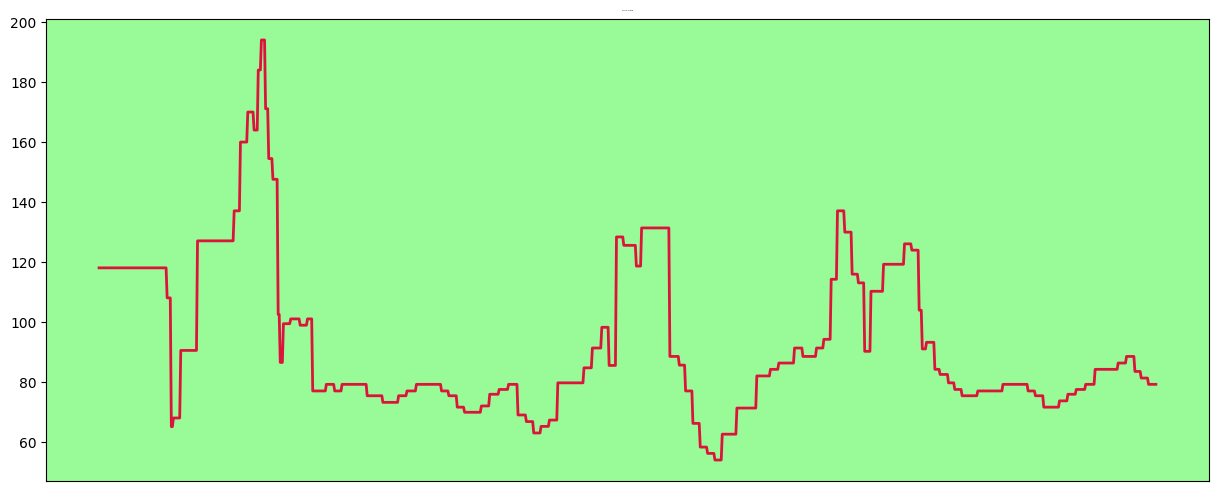

In [3]:
plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['avg_bpm'], lw=2, color = 'crimson')
ax = plt.gca()
ax.set_facecolor('palegreen')
plt.title('Grafica Original', fontsize=0.2)
plt.xticks([])  # Elimina todas las etiquetas del eje X

In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['avg_bpm'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.704039
p-value: 0.073342


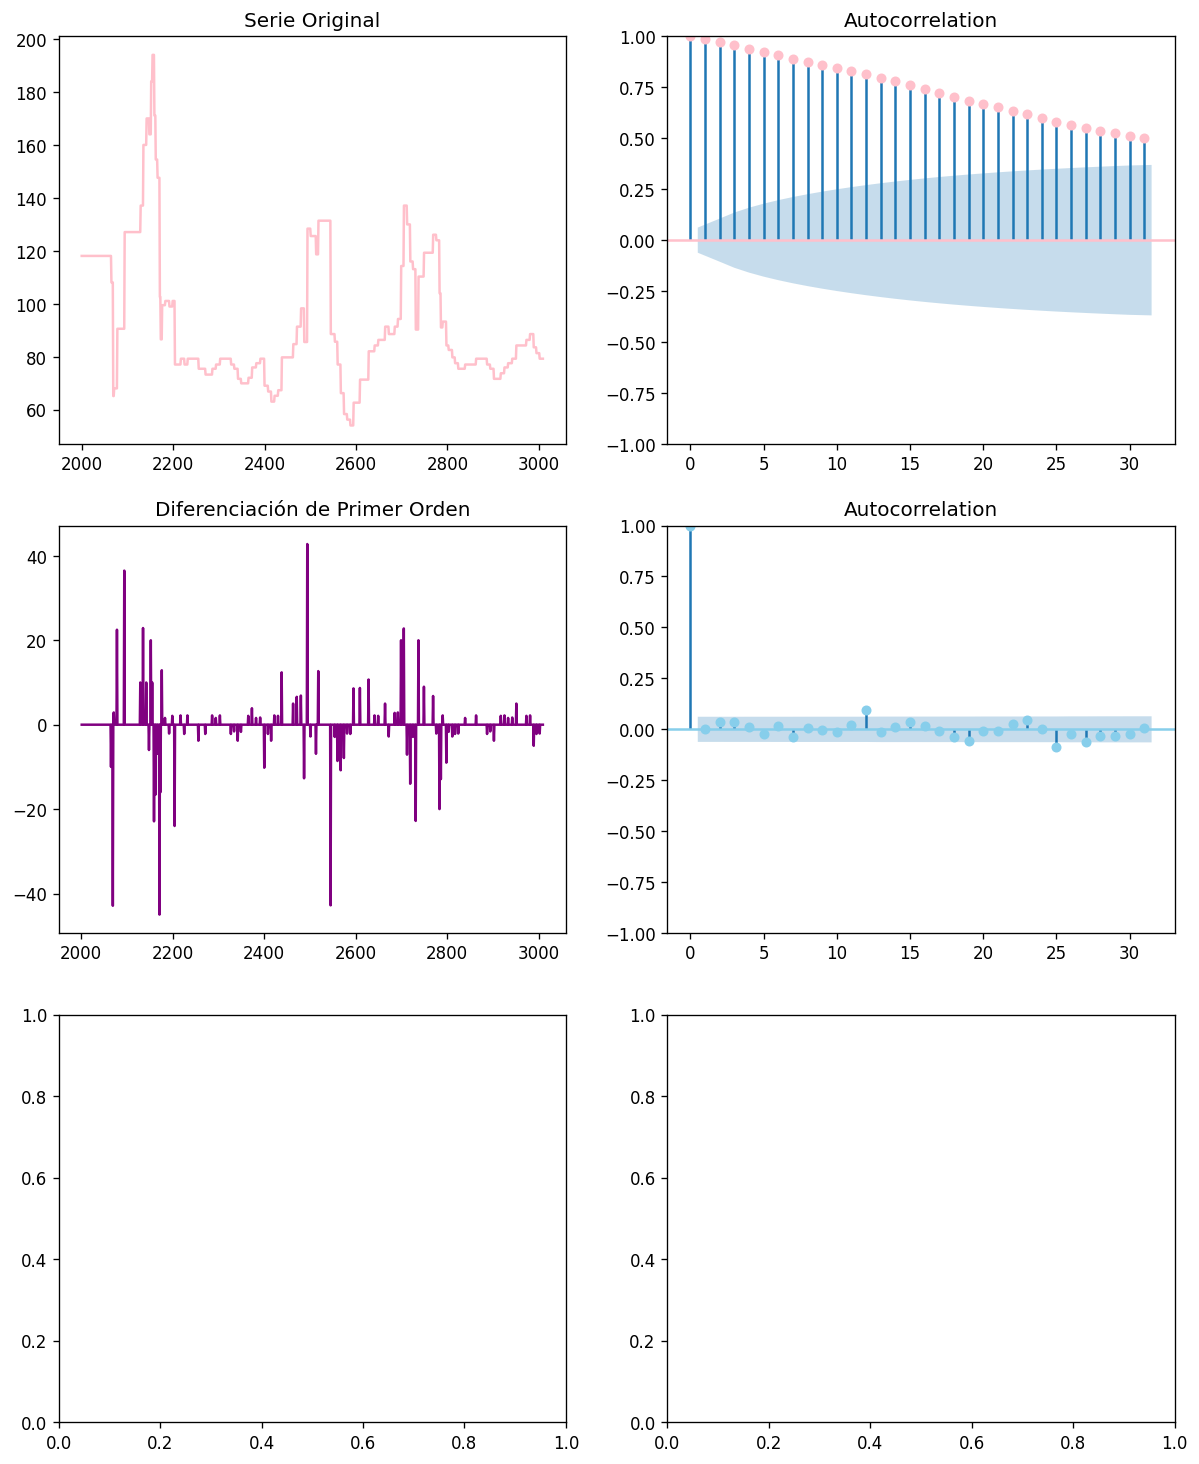

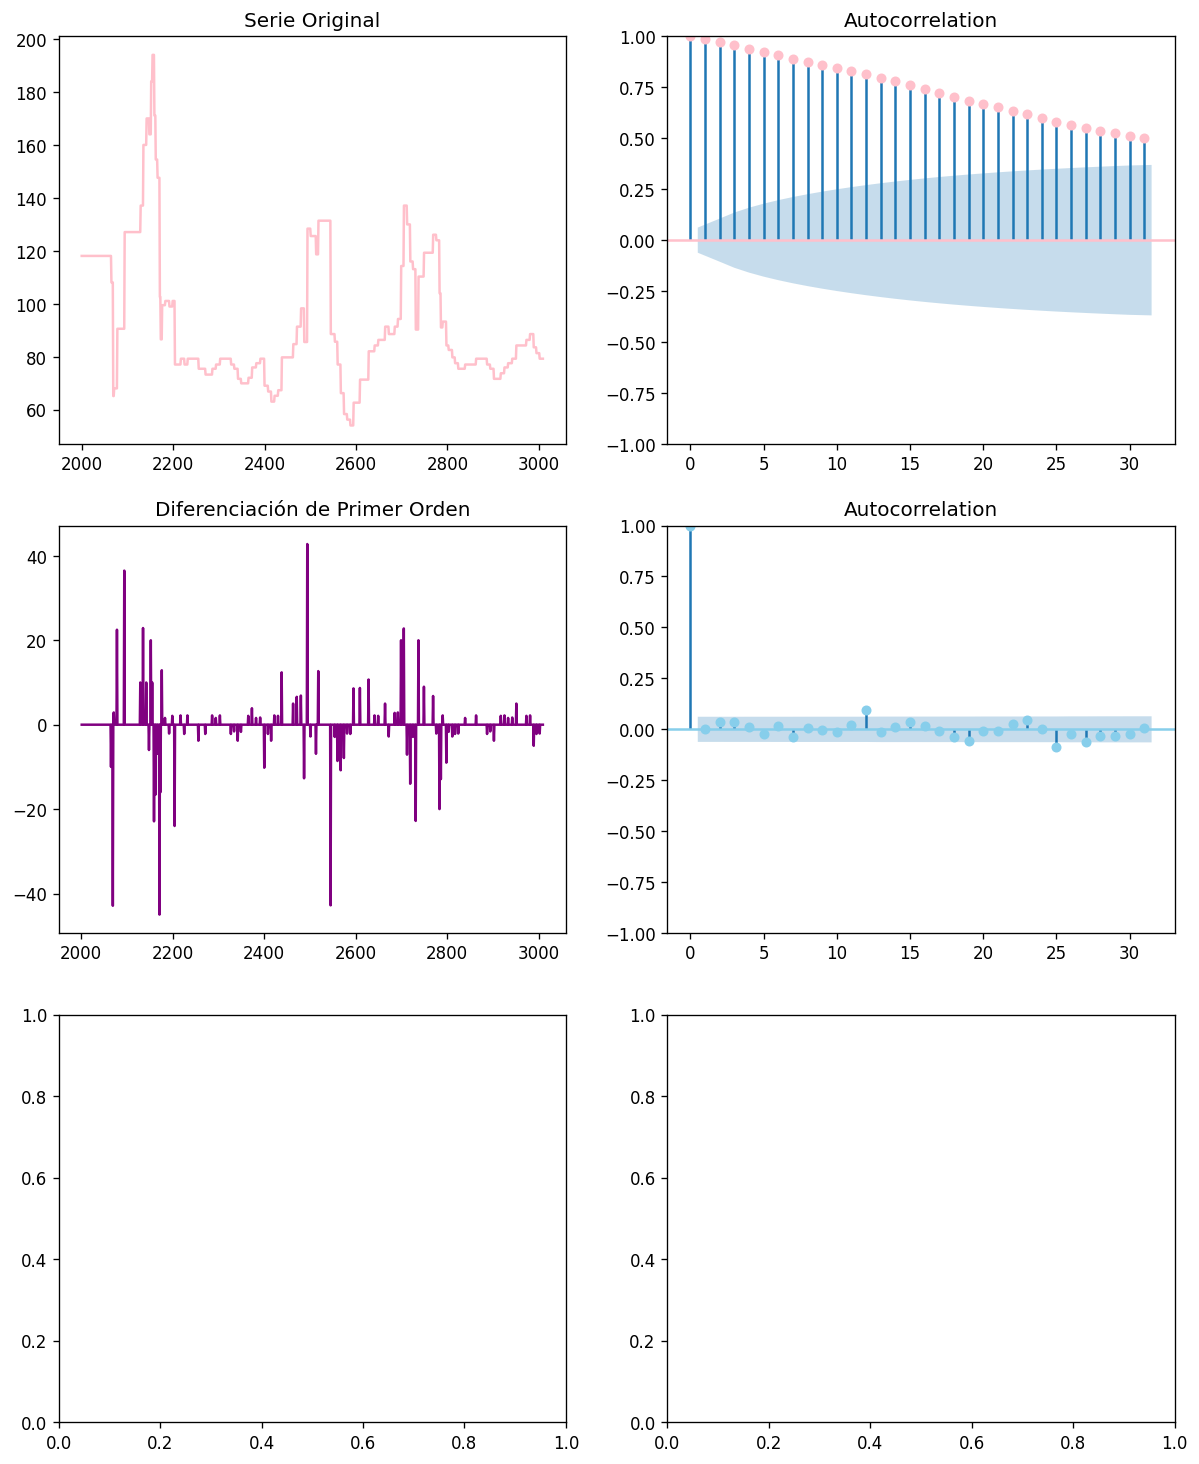

In [5]:
plt.rcParams.update({'figure.figsize': (12, 15), 'figure.dpi': 120})

# Serie original
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df['avg_bpm'], color='pink')
axes[0, 0].set_title('Serie Original')
plot_acf(df['avg_bpm'], ax=axes[0, 1], color='pink')

# Primera diferenciación
axes[1, 0].plot(df['avg_bpm'].diff(), color="purple")
axes[1, 0].set_title("Diferenciación de Primer Orden")
plot_acf(df['avg_bpm'].diff().dropna(), ax=axes[1, 1], color='skyblue')

# Segunda diferenciación
#axes[2, 0].plot(df['meantemp'].diff().diff(), color='aqua') 
#axes[2, 0].set_title("Diferenciación de Segundo Orden")
#plot_acf(df['meantemp'].diff().diff().dropna(), ax=axes[2, 1], color="black")

Para la serie anterior la serie temporal alcanza estacionalidad con dos órdenes de diferenciación, pero al mirar el gráfico de autocorrelacion para la segunda diferenciación el retraso entra en la zona zona negativa lejana bastante rápido 

In [6]:
result = adfuller(df['avg_bpm'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#result2 = adfuller(df['meantemp'].diff().diff().dropna())
#print('ADF Statistic: %f' % result2[0])
#print('p-value: %f' % result2[1])

ADF Statistic: -31.720278
p-value: 0.000000


El valor de d = 1 "Una sola diferenciacion"
La autocorrelación parcial es la correlacion entre la serie y su rezago despues de excluir las contribuciones de los rezagos intermedios

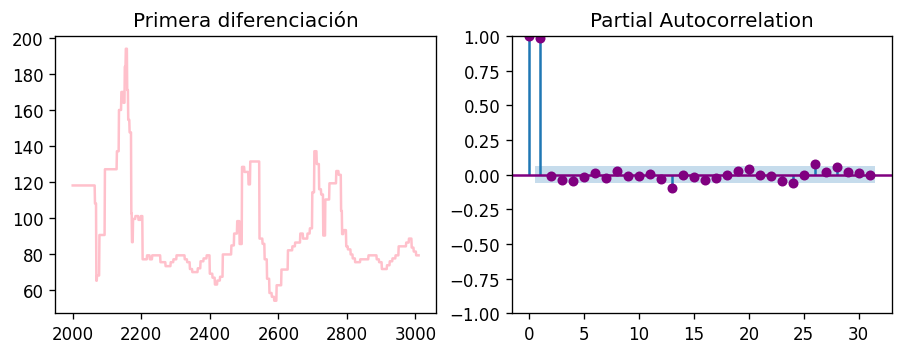

In [7]:
# Autocorrelación parcial (PACF) PLOT
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2, sharex=False)

# Primera diferenciación
axes[0].plot(df['avg_bpm'], color='pink')
axes[0].set_title("Primera diferenciación")

# PACF plot
plot_pacf(df['avg_bpm'], ax=axes[1], color='purple')

plt.show()

Valor AR  = Valor más significativo de la Autocorrelacion Parcial. En este caso es 1
Valor media movil (MA): Un termino MA es el arror del pronóstico retrasado. El punto del intervalo de confianza que sobresale del mismo. Q12
Si la serie está ligeramente por debajo o por encima de la diferencia, agregar uno o más términos AR adicionales generalmente lo compensa

In [8]:
#data = df[['time', 'bpm']]

# Convertir la columna 'date' a tipo datetime
#data['time'] = pd.to_datetime(data['time'])

# Establecer 'date' como índice
#data.set_index('time', inplace=True)
#data

In [9]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Ajustar el modelo ARIMA con los datos escalados
model = auto_arima(df['avg_bpm'].diff().dropna(),seasonal=True, m=20)
model = model.fit(df['avg_bpm'])
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1010
Model:                        SARIMAX   Log Likelihood               -6042.582
Date:                Sat, 29 Mar 2025   AIC                          12087.163
Time:                        06:11:53   BIC                          12092.081
Sample:                             0   HQIC                         12089.031
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9206.1869    979.945      9.395      0.000    7285.530    1.11e+04
Ljung-Box (L1) (Q):                 984.21   Jarque-Bera (JB):               334.36
Prob(Q):                              0.00   Pr

Si el coeficiente MA1/ MA2 es cercano a cero y el p valor 'P>|z| es muy insignificante que deberia ser 0.05 para que la X sea significativa reconstruimos el modelo sin el termino MA2

In [10]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(model.resid(), lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,8548.119209,0.0


Hipotesis de Ljung-Box

Ruido blanco significa que el error:
Media = 0 , varianza Constante
H0; Ruido blanco
H1: No hay ruido blanco
Si en la prueba de Ljung Box el pvalor > 0.05 significa que nuestro modelo se ajusta bien y existe ruido blanco. Si el p-valor < 0.05 el modelo no se ajusta bien

In [11]:
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

# Residuos del modelo
residuals = pd.DataFrame(results.resid, columns=['Residuals'])

# Crear subgráficos
fig, ax = plt.subplots(1, 2)

# Gráfico de residuos
residuals.plot(title="Residuales", ax=ax[0], color="orchid", lw=2)

# Gráfico de densidad (KDE)
residuals.plot(kind='kde', title="Densidad", ax=ax[1], color="orchid", lw=2)

# Mostrar gráficos
plt.show()

NameError: name 'results' is not defined

errores residuales parecen estar bien con una media cercana a cero y una varianza uniforme

                                     SARIMAX Results                                      
Dep. Variable:                            avg_bpm   No. Observations:                 1010
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 24)   Log Likelihood               -2858.735
Date:                            Sat, 29 Mar 2025   AIC                           5721.470
Time:                                    06:12:14   BIC                           5731.303
Sample:                                         0   HQIC                          5725.205
                                           - 1010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.0031      0.021      0.147      0.883      -0.038       0.045
sigma2        16.9211      0.133   

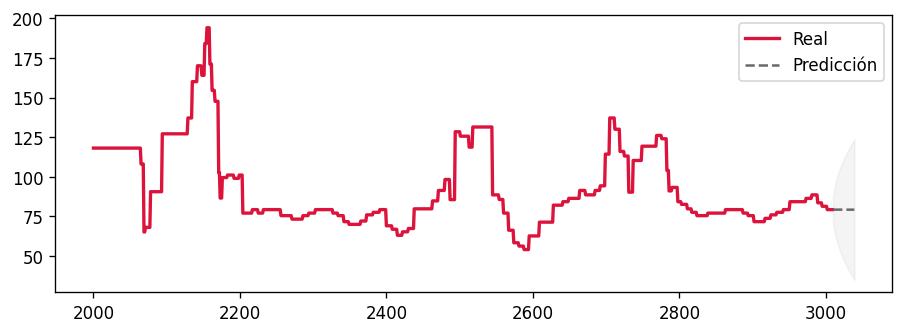

-0.2898941020184824
28.257372568910252


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['avg_bpm'], order=(0, 1, 0), seasonal_order=(1, 0, 0, 24))
results = model.fit()
print(results.summary())
# Predicciones
forecast = results.get_forecast(steps=30)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Gráfico
plt.plot(df['avg_bpm'], label='Real', color='crimson', lw=2)
plt.plot(pred_mean, label='Predicción', linestyle='--', color='dimgray')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gainsboro', alpha=0.3)
ax.set_facecolor('palegreen')
plt.legend()
plt.show()
# In-sample predictions
in_sample_pred = results.get_prediction(start=df.index[0], end=df.index[-1])
in_sample_pred_mean = in_sample_pred.predicted_mean

# Calculate R2 score

print(r2_score(df['avg_bpm'], in_sample_pred_mean))
# Calculate RMSE
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(df['avg_bpm'], in_sample_pred_mean)))